In [1]:
# prompt: Upload file to the runtime

from google.colab import files
uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))


Saving impact.csv to impact.csv
User uploaded file "impact.csv" with length 9742 bytes


In [2]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("sharjeelmazhar/human-activity-recognition-video-dataset")

print("Path to dataset files:", path)


100%|██████████| 14.8G/14.8G [02:52<00:00, 92.4MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/sharjeelmazhar/human-activity-recognition-video-dataset/versions/1


In [3]:
!ls '/root/.cache/kagglehub/datasets/sharjeelmazhar/human-activity-recognition-video-dataset/versions/1/Human Activity Recognition - Video Dataset'

 Clapping	   Sitting	     Walking			  'Walking While Using Phone'
'Meet and Split'  'Standing Still'  'Walking While Reading Book'


In [4]:
# move the dataset to the correct location
import shutil
shutil.move(path, "..")

'../1'

In [5]:

# rename the directory in data to remove the spaces
shutil.move("../1/Human Activity Recognition - Video Dataset", "../HumanActivityRecognition-VideoDataset")

'../HumanActivityRecognition-VideoDataset'

In [6]:
shutil.move("../HumanActivityRecognition-VideoDataset/Meet and Split", "../HumanActivityRecognition-VideoDataset/MeetAndSplit")
shutil.move("../HumanActivityRecognition-VideoDataset/Standing Still", "../HumanActivityRecognition-VideoDataset/StandingStill")
shutil.move("../HumanActivityRecognition-VideoDataset/Walking While Reading Book", "../HumanActivityRecognition-VideoDataset/WalkingWhileReadingBook")
shutil.move("../HumanActivityRecognition-VideoDataset/Walking While Using Phone", "../HumanActivityRecognition-VideoDataset/WalkingWhileUsingPhone")


'../HumanActivityRecognition-VideoDataset/WalkingWhileUsingPhone'

In [7]:
import tensorflow as tf
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [8]:

# Read the CSV file
csv_file_path = 'impact.csv'
data = pd.read_csv(csv_file_path)

In [9]:
def load_frame(video_path, frame_index, image_size=(224, 224)):
    cap = cv2.VideoCapture(video_path)
    cap.set(cv2.CAP_PROP_POS_FRAMES, frame_index)
    ret, frame = cap.read()
    cap.release()
    if not ret:
        raise ValueError(f"Frame {frame_index} not found in video {video_path}")
    frame = cv2.resize(frame, image_size)
    frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    return frame

def load_data(data, image_size=(224, 224)):
    frames_n_list = []
    frames_m_list = []
    perceived_changes = []
    for index, row in data.iterrows():
        video_path = row['Video']
        frame_n = int(row['Frame n'])
        frame_m = int(row['Frame m'])
        perceived_change = row['Perceived Change']

        frame_n = load_frame(video_path, frame_n, image_size)
        frame_m = load_frame(video_path, frame_m, image_size)

        frames_n_list.append(frame_n)
        frames_m_list.append(frame_m)
        perceived_changes.append(perceived_change)

    return frames_n_list, frames_m_list, perceived_changes

0.27592835


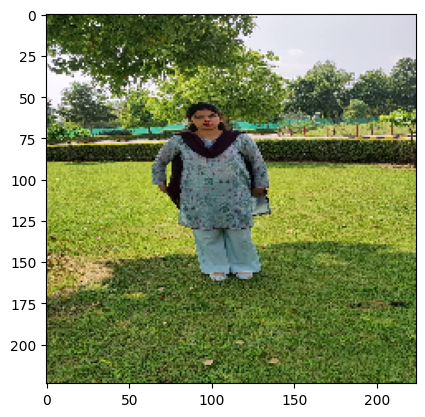

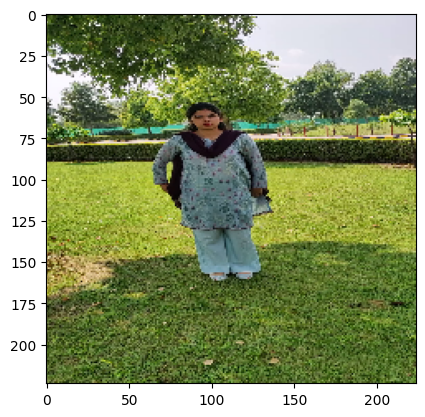

In [10]:
frames_n, frames_m, perceived_changes = load_data(data)

# Print the first n and m frame and the perceived change
print(perceived_changes[0])
plt.imshow(frames_n[0])
plt.show()
plt.imshow(frames_m[0])
plt.show()


In [11]:
! ls ../HumanActivityRecognition-VideoDataset/

Clapping      Sitting	     Walking		      WalkingWhileUsingPhone
MeetAndSplit  StandingStill  WalkingWhileReadingBook


In [12]:
# normalize the images
frames_n = np.array(frames_n) / 255.0
frames_m = np.array(frames_m) / 255.0
# Calculate the minimum and maximum values
min_value = np.min(perceived_changes)
max_value = np.max(perceived_changes)
# Apply Min-Max normalization
perceived_changes = (perceived_changes - min_value) / (max_value - min_value)

In [13]:
# Shuffle the data
indices = np.arange(len(perceived_changes))
np.random.shuffle(indices)

frames_n = tf.gather(frames_n, indices)
frames_m = tf.gather(frames_m, indices)
perceived_changes = tf.gather(perceived_changes, indices)

In [14]:
# Split the data into training, validation, and test sets
train_ratio = 0.6
val_ratio = 0.2
test_ratio = 0.2

# Calculate the split indices
num_samples = len(perceived_changes)
train_end = int(train_ratio * num_samples)
val_end = train_end + int(val_ratio * num_samples)

# Split the data
frames_n_train = frames_n[:train_end]
frames_m_train = frames_m[:train_end]
perceived_changes_train = perceived_changes[:train_end]

frames_n_val = frames_n[train_end:val_end]
frames_m_val = frames_m[train_end:val_end]
perceived_changes_val = perceived_changes[train_end:val_end]

frames_n_test = frames_n[val_end:]
frames_m_test = frames_m[val_end:]
perceived_changes_test = perceived_changes[val_end:]




In [15]:
frames_m_test.shape

TensorShape([6, 224, 224, 3])

In [16]:
# Create a TensorFlow dataset
train_dataset = tf.data.Dataset.from_tensor_slices(((frames_n_train, frames_m_train), perceived_changes_train))
val_dataset = tf.data.Dataset.from_tensor_slices(((frames_n_val, frames_m_val), perceived_changes_val))
test_dataset = tf.data.Dataset.from_tensor_slices(((frames_n_test, frames_m_test), perceived_changes_test))

# Shuffle and batch the dataset
batch_size = 32
train_dataset = train_dataset.shuffle(buffer_size=len(perceived_changes)).batch(batch_size).prefetch(tf.data.AUTOTUNE)
val_dataset = val_dataset.batch(batch_size).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(batch_size).prefetch(tf.data.AUTOTUNE)

In [17]:
# Define the neural network model
input_n = tf.keras.layers.Input(shape=(224, 224, 3))
input_m = tf.keras.layers.Input(shape=(224, 224, 3))

# Shared convolutional base
base_model = tf.keras.applications.MobileNetV3Small(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False
x_n = base_model(input_n)
x_m = base_model(input_m)

# Global average pooling
x_n = tf.keras.layers.GlobalAveragePooling2D()(x_n)
x_m = tf.keras.layers.GlobalAveragePooling2D()(x_m)

# Concatenate the outputs
x = tf.keras.layers.Concatenate()([x_n, x_m])

# Fully connected layer
x = tf.keras.layers.Dense(128, activation='relu')(x)
output = tf.keras.layers.Dense(1, activation='linear')(x)

model = tf.keras.models.Model(inputs=[input_n, input_m], outputs=output)



4334752/4334752 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [18]:
model.trainable_variables


[<KerasVariable shape=(1152, 128), dtype=float32, path=dense/kernel>,
 <KerasVariable shape=(128,), dtype=float32, path=dense/bias>,
 <KerasVariable shape=(128, 1), dtype=float32, path=dense_1/kernel>,
 <KerasVariable shape=(1,), dtype=float32, path=dense_1/bias>]

In [19]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 224, 224, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ input_layer_1             │ (None, 224, 224, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ MobileNetV3Small          │ (None, 7, 7, 576)      │        939,120 │ input_layer[0][0],     │
│ (Functional)              │                        │                │ input_layer_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ global_average_pooling2d  │ (None, 576)            │              0 │ MobileNetV3Small[0][0] │
│ (GlobalAveragePooling2D)  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ global_average_pooling2d… │ (None, 576)            │              0 │ MobileNetV3Small[1][0] │
│ (GlobalAveragePooling2D)  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate (Concatenate) │ (None, 1152)           │              0 │ global_average_poolin… │
│                           │                        │                │ global_average_poolin… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense (Dense)             │ (None, 128)            │        147,584 │ concatenate[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_1 (Dense)           │ (None, 1)              │            129 │ dense[0][0]            │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 1,086,833 (4.15 MB)

 Trainable params: 147,713 (577.00 KB)

 Non-trainable params: 939,120 (3.58 MB)

In [20]:
# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])

# Train the model
epochs = 10
model.fit(train_dataset, validation_data=val_dataset, epochs=epochs)

Epoch 1/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 13s 13s/step - loss: 0.3117 - mae: 0.4474 - val_loss: 0.7570 - val_mae: 0.8414
Epoch 2/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 342ms/step - loss: 0.5848 - mae: 0.6840 - val_loss: 0.3708 - val_mae: 0.5674
Epoch 3/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 321ms/step - loss: 0.2850 - mae: 0.4333 - val_loss: 0.0555 - val_mae: 0.2163
Epoch 4/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 308ms/step - loss: 0.1216 - mae: 0.3160 - val_loss: 0.1178 - val_mae: 0.2633
Epoch 5/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 331ms/step - loss: 0.2918 - mae: 0.4310 - val_loss: 0.1361 - val_mae: 0.2960
Epoch 6/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 574ms/step - loss: 0.3202 - mae: 0.4546 - val_loss: 0.0595 - val_mae: 0.1862
Epoch 7/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 291ms/step - loss: 0.1841 - mae: 0.3481 - val_loss: 0.0795 - val_mae: 0.2628
Epoch 8/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 323ms/step - loss: 0.1165 - mae: 0.3152 - val_loss: 0.2196 - val_mae: 0.4133
Epoch 9/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 315ms/step - loss: 0.1821 - mae: 0

In [21]:
test_loss, test_mae = model.evaluate(test_dataset)
print(f'Test loss: {test_loss}')
print(f'Test MAE: {test_mae}')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step - loss: 0.1485 - mae: 0.3309
Test loss: 0.14848117530345917
Test MAE: 0.33092865347862244
